In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

data= fetch_openml('mnist_784', version=1)#Get data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],data["target"]],columns = data["feature_names"]+["target"])

In [2]:
img_pipeline = Pipeline([("mm_scaler", MinMaxScaler())])
y = dfData["target"]
dfData = dfData.drop("target",axis=1)
X = dfData.copy()
X_transf = img_pipeline.fit_transform(X)

In [3]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in stratSplit.split(X_transf, y):
    X_train = X_transf[train_index]
    X_test = X_transf[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]

In [4]:
log_reg = LogisticRegression(C=1e5, max_iter=100)
def performCV(log_reg, X_train, y_train):
    return cross_validate(log_reg,
                             X = X_train,
                             y = y_train,
                            scoring = "accuracy",
                            cv = 2,
                            n_jobs=-1,
                            verbose = False,
                            return_train_score=True,
                            return_estimator=True)
results = performCV(log_reg, X_train, y_train)

In [5]:
bestEstInd = np.argmax(results["test_score"])
best_estimator = results["estimator"][bestEstInd]
feature_importaces_zero = best_estimator.coef_[0]

In [16]:
print(best_estimator.coef_.shape)
best_estimator.coef_

(10, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

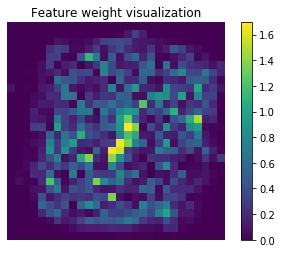

In [6]:
dfImp = pd.DataFrame({"feature":dfData.columns,
                     "weight":feature_importaces_zero,
                     "weightAbs":np.absolute(feature_importaces_zero)})

featureWeights = np.abs(dfImp["weight"].values)
# featureWeights[featureWeights<0.1]=0
plt.imshow(featureWeights.reshape(28,28))
plt.axis('off')
plt.colorbar()
plt.title("Feature weight visualization")
plt.show()

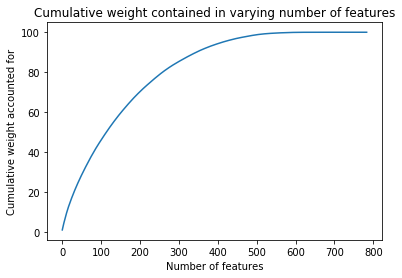

# feautres that contain 99% of weight: 511
Weight of next feature: -0.0410069994804807


In [7]:
dfImpCumImp = dfImp.sort_values("weightAbs",ascending=False).reset_index(drop=True)
dfImpCumImp["cumSumWeights"] = dfImpCumImp["weightAbs"].cumsum()
dfImpCumImp["cumSumPerc"] = 100*dfImpCumImp["weightAbs"].cumsum()/dfImpCumImp["cumSumWeights"].iloc[-1]
plt.plot(dfImpCumImp.index,dfImpCumImp["cumSumPerc"])
plt.title("Cumulative weight contained in varying number of features")
plt.xlabel("Number of features")
plt.ylabel("Cumulative weight accounted for")
plt.show()
xPercTotalWeightsInd = dfImpCumImp.loc[dfImpCumImp["cumSumPerc"]<99].index[-1]
print("# feautres that contain 99% of weight:",xPercTotalWeightsInd+1)
print("Weight of next feature:",dfImpCumImp.iloc[xPercTotalWeightsInd+1]["weight"])

In [8]:
dfImp.sort_values("weight", ascending=False, inplace=True)
print(dfImp.head())
print(dfImp.tail())

      feature    weight  weightAbs
360  pixel361  1.486658   1.486658
486  pixel487  1.367401   1.367401
571  pixel572  1.359213   1.359213
629  pixel630  1.356449   1.356449
297  pixel298  1.241280   1.241280
      feature    weight  weightAbs
489  pixel490 -1.406090   1.406090
462  pixel463 -1.575566   1.575566
461  pixel462 -1.661692   1.661692
434  pixel435 -1.680010   1.680010
379  pixel380 -1.694818   1.694818


In [17]:
sorted(zip(feature_importaces_zero, dfData.columns), reverse=True)

[(1.4866578731081757, 'pixel361'),
 (1.3674010158525036, 'pixel487'),
 (1.3592131174269804, 'pixel572'),
 (1.3564494571039485, 'pixel630'),
 (1.2412800044205667, 'pixel298'),
 (1.2200278436626484, 'pixel566'),
 (1.1143669331692532, 'pixel123'),
 (1.0891398981352691, 'pixel330'),
 (1.0552973454192056, 'pixel360'),
 (1.0541680553276034, 'pixel402'),
 (1.034617438728585, 'pixel486'),
 (1.011372468584043, 'pixel249'),
 (0.9712685117041872, 'pixel371'),
 (0.9364785977767779, 'pixel429'),
 (0.9297887433700794, 'pixel389'),
 (0.9244572074782446, 'pixel241'),
 (0.9097535458931083, 'pixel441'),
 (0.8760223238693711, 'pixel272'),
 (0.8633066658786293, 'pixel454'),
 (0.8494698398134948, 'pixel456'),
 (0.8347184910203241, 'pixel245'),
 (0.8200042560992816, 'pixel655'),
 (0.8172116405833657, 'pixel573'),
 (0.814774834607191, 'pixel273'),
 (0.8123052176046539, 'pixel191'),
 (0.8032013149892232, 'pixel388'),
 (0.7574785322430885, 'pixel426'),
 (0.7506219406797613, 'pixel277'),
 (0.7289260192783065, '

In [10]:
impFeat = dfImp.loc[(dfImp["weight"]>0.04)|(dfImp["weight"]<-0.04)]["feature"]
impFeat

360    pixel361
486    pixel487
571    pixel572
629    pixel630
297    pixel298
         ...   
489    pixel490
462    pixel463
461    pixel462
434    pixel435
379    pixel380
Name: feature, Length: 515, dtype: object

In [11]:
X_transf_red = img_pipeline.fit_transform(X[impFeat])
for train_index, test_index in stratSplit.split(X_transf_red, y):
    X_train_red = X_transf_red[train_index]
    X_test_red = X_transf_red[test_index]
    
    y_train_red = y[train_index]
    y_test_red = y[test_index]

In [12]:
results_red = performCV(log_reg, X_train_red, y_train_red)

In [13]:
X_train_red.shape

(56000, 515)

In [14]:
def printCVPerformance(results,results_red):
    print("Number of features all:",results["estimator"][0].coef_.shape[1])
    print("Number of features reduced:",results_red["estimator"][0].coef_.shape[1])
    print("Test sccores with all features:",round(np.mean(results["test_score"]),4))
    print("Test sccores with reduced feature set:",round(np.mean(results_red["test_score"]),4))
    print()
    print("Average train time all features:",round(np.mean(results["fit_time"]),2))
    print("Average train time all features:",round(np.mean(results_red["fit_time"]),2))
printCVPerformance(results,results_red)

Number of features all: 784
Number of features reduced: 515
Test sccores with all features: 0.9119
Test sccores with reduced feature set: 0.9129

Average train time all features: 11.67
Average train time all features: 8.33


In [15]:
for max_iter in [100,500,1000]:
    log_reg = LogisticRegression(C=1e5, max_iter=max_iter)
    results = performCV(log_reg, X_train, y_train)
    results_red = performCV(log_reg, X_train_red, y_train_red)
    print("Performance for max_iter:",max_iter)
    printCVPerformance(results,results_red)
    print("\n")

Performance for max_iter: 100
Number of features all: 784
Number of features reduced: 515
Test sccores with all features: 0.9119
Test sccores with reduced feature set: 0.9129

Average train time all features: 11.39
Average train time all features: 7.77


Performance for max_iter: 500
Number of features all: 784
Number of features reduced: 515
Test sccores with all features: 0.8964
Test sccores with reduced feature set: 0.8978

Average train time all features: 49.77
Average train time all features: 33.49


Performance for max_iter: 1000
Number of features all: 784
Number of features reduced: 515
Test sccores with all features: 0.8903
Test sccores with reduced feature set: 0.8959

Average train time all features: 92.79
Average train time all features: 65.36


